
# Laboratory 3: Business Cycle Facts and Real Business Cycles Model - Homework Solutions
#### Group K members:
- Akabi Bastiana (490334)
- Doliev Mekhroj (487990)
- Khudayberganov Asadbek (436840)
- Nomcoyiya Nomakhephu (488379)
- Wójcik Artur (394608)


## Homework: Part A.  The business cycles

**Task 1**: Divide the sample into two before 1980 and after 1980 and calculate the business cycle statistics, i.e., standard deviation, correlation with output and auto correlation. Compare the results and provide general interpretation. (You do not need to recalculate variables for each sample. You only need to calculate statistics for each sample from already built variables)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas_datareader.data import DataReader

# Code copied from Lab 3 RBC
start = '1945-01'
end   = '2025-12'
pop = DataReader(['B230RC0Q173SBEA', 'CNP16OV'], 'fred', start=start, end=end)
pop = pop.resample('QS').mean()
pop = pop.dropna()

fred = DataReader(['GDP', 'PCND', 'PCESV', 'PCDG', 'FPI', 'GDPDEF',
                   'PRS85006053', 'HOANBS', 'COMPNFB', 'TB3MS'],
                  'fred', start=start, end=end)
fred = fred.resample('QS').mean()
fred = fred.dropna()

pop_hp_cycle = pd.DataFrame()
pop_hp_trend = pd.DataFrame()

for col in pop.columns:
    pop_hp_cycle[col], pop_hp_trend[col] = sm.tsa.filters.hpfilter(np.log(pop[col]), lamb=1600)
    
pop_smooth = np.exp(pop_hp_trend)


dta = pd.DataFrame()

dta['Output'] = np.log(fred['GDP']*10**9/fred['GDPDEF']*100
                       /(pop_smooth['CNP16OV']*10**3))

dta['Consumption'] = np.log((fred['PCND']+fred['PCESV'])*10**9/fred['GDPDEF']*100
                            /(pop_smooth['CNP16OV']*10**3))

dta['Investment'] = np.log((fred['PCDG']+fred['FPI'])*10**9/fred['GDPDEF']*100
                           /(pop_smooth['CNP16OV']*10**3))

dta['Capital'] = 0*dta['Output']

dta['Hours'] = np.log(fred['HOANBS']*100*fred['GDP']/np.mean(fred['GDP']['2017-01':'2017-10'])
                      /fred['PRS85006053']/pop_smooth['CNP16OV'])

dta['Wages'] = np.log(fred['COMPNFB']/fred['GDPDEF']*100)

dta['Interest Rate'] = np.log( (1+fred['TB3MS']/100)**(1/4)/(1+fred['GDPDEF'].pct_change()) )

dta['TFP'] = 0*dta['Output']

dta['Productivity'] = np.log(fred['PRS85006053']/fred['GDPDEF']*100)-dta['Hours']

dta['Price Level'] = np.log(fred['GDPDEF'])

dta = dta.dropna()
# Estimate Capital series using PIM
temp = pd.DataFrame()

temp['Inv'] = (fred['PCDG']+fred['FPI'])/fred['GDPDEF']*100/4
temp['LnInv'] = np.log(temp['Inv'])
temp['t'] = np.arange(len(temp['Inv']))

trend = smf.ols(formula='LnInv ~ t', data=temp).fit()
intercept, slope = trend.params
print(trend.summary())


delta = 0.025
K = np.zeros(len(temp['LnInv']))
K_init = np.exp(intercept-slope)/(slope+delta)

K[0] = (1-delta)*K_init+temp['Inv'][0]
for i in range(1,len(temp['Inv'])):
    K[i] = (1-delta)*K[i-1]+temp['Inv'][i]
temp['Cap'] = K
dta['Capital'] = np.log(temp['Cap']*10**9/(pop_smooth['CNP16OV']*10**3))

α = 1/3
dta['TFP'] = dta['Output']-α*dta['Capital']-(1-α)*dta['Hours']

hp_cycles = pd.DataFrame()
hp_trend = pd.DataFrame()

cf_cycles = pd.DataFrame()
cf_trend = pd.DataFrame()

for col in dta.columns:
    hp_cycles[col], hp_trend[col] = sm.tsa.filters.hpfilter((100*dta[col]).dropna(), lamb=1600)
    cf_cycles[col], cf_trend[col] = sm.tsa.filters.cffilter((100*dta[col]).dropna(), low=6, high=32)

                            OLS Regression Results                            
Dep. Variable:                  LnInv   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.038e+04
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          1.66e-241
Time:                        22:33:33   Log-Likelihood:                 217.22
No. Observations:                 314   AIC:                            -430.4
Df Residuals:                     312   BIC:                            -422.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0411      0.014    368.375      0.0

c:\Users\aaa\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\aaa\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
C:\Users\aaa\AppData\Local\Temp\ipykernel_79244\419324545.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  K[0] = (1-delta)*K_init+temp['Inv'][0]
C:\Users\aaa\AppData\Local\Temp\ipykernel_79244\419324545.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, 

In [2]:
print(f"Standard Deviations\n{'Series':<20}{'Before 1980':>15}{'After 1980':>15}{'Change (%)':>15}{'Excl COVID':>15}{'Change (%)':>15}")
for col in hp_cycles.columns:
    before = hp_cycles[col].loc[:'1980-01-01'].std()  # exclude 1980-01-01
    after  = hp_cycles[col].loc['1979-12-31':].std()
    change = 100 * (after - before) / before
    after_2  = hp_cycles[col].loc['1979-12-31':'2020-01-31'].std()
    change_2 = 100 * (after_2 - before) / before
    print(f"{col:<20}{before:>15.4f}{after:>15.4f}{change:>15.0f}{after_2:>15.4f}{change_2:>15.0f}")




Standard Deviations
Series                  Before 1980     After 1980     Change (%)     Excl COVID     Change (%)
Output                       1.9280         1.3801            -28         1.2627            -35
Consumption                  0.8783         1.2094             38         0.8754             -0
Investment                   5.0538         3.8078            -25         3.9298            -22
Capital                      0.5548         0.5353             -4         0.5650              2
Hours                        1.8445         1.6741             -9         1.4413            -22
Wages                        0.5862         1.2630            115         1.0137             73
Interest Rate                0.4964         0.3637            -27         0.2713            -45
TFP                          1.1724         0.8219            -30         0.8114            -31
Productivity                 1.5785         1.0401            -34         1.0313            -35
Price Level         

In [3]:
print(f"Autocorrelations\n{'Series':<20}{'Before 1980':>15}{'After 1980':>15}{'Change (%)':>15}{'Excl COVID':>15}{'Change (%)':>15}")
for col in dta.columns.values[:10]:
    before = hp_cycles[col].loc[:'1980-01-01'].autocorr()  # exclude 1980-01-01
    after  = hp_cycles[col].loc['1979-12-31':].autocorr()
    change = 100 * (after - before) / before
    after_2  = hp_cycles[col].loc['1979-12-31':'2020-01-31'].autocorr()
    change_2 = 100 * (after_2 - before) / before
    print(f"{col:<20}{before:>15.4f}{after:>15.4f}{change:>15.0f}{after_2:>15.4f}{change_2:>15.0f}")

Autocorrelations
Series                  Before 1980     After 1980     Change (%)     Excl COVID     Change (%)
Output                       0.8371         0.7130            -15         0.8683              4
Consumption                  0.7928         0.6182            -22         0.8572              8
Investment                   0.8348         0.8880              6         0.9090              9
Capital                      0.9513         0.9768              3         0.9781              3
Hours                        0.8888         0.7605            -14         0.9269              4
Wages                        0.5712         0.7331             28         0.7107             24
Interest Rate                0.3599         0.6607             84         0.5728             59
TFP                          0.6729         0.7174              7         0.7455             11
Productivity                 0.6210         0.6688              8         0.6850             10
Price Level            

In [4]:
print('Correlations with Output')
corr_bf_1980 = hp_cycles.loc[:'1980-01-01'].corr(method='pearson')
corr_af_1980 = hp_cycles.loc['1979-12-31':].corr(method='pearson')
corr_af_1980_2020 = hp_cycles.loc['1979-12-31':'2020-01-31'].corr(method='pearson')
print(f"{'Series':<20}{'Before 1980':>15}{'After 1980':>15}{'Change (%)':>15}{'Excl COVID':>15}{'Change (%)':>15}")

for col in hp_cycles.columns:
    before = corr_bf_1980.loc["Output", col]
    after  = corr_af_1980.loc["Output", col]
    change = 100 * (after - before) / before
    after_2  = corr_af_1980_2020.loc["Output", col]
    change_2 = 100 * (after_2 - before) / before
    print(f"{col:<20}{before:>15.4f}{after:>15.4f}{change:>15.0f}{after_2:>15.4f}{change_2:>15.0f}")

Correlations with Output
Series                  Before 1980     After 1980     Change (%)     Excl COVID     Change (%)
Output                       1.0000         1.0000              0         1.0000              0
Consumption                  0.7326         0.8320             14         0.8011              9
Investment                   0.7246         0.8361             15         0.8793             21
Capital                      0.4657         0.2890            -38         0.3001            -36
Hours                        0.8169         0.8271              1         0.7993             -2
Wages                        0.2687        -0.2472           -192        -0.0663           -125
Interest Rate               -0.0928         0.0946           -202         0.3247           -450
TFP                          0.7143         0.4933            -31         0.5400            -24
Productivity                 0.4609         0.4488             -3         0.5168             12
Price Level    

### Standard Deviations
Most of the indicators show an decrease in standard deviation after 1980 with exception of Wages and Consumption. This period is known as the **Great Moderation** when improved monetary policies and other factors led to reduced volatility in economic output and other macroeconomic variables. The increase in consumption volatility was likely driven by the COVID-19 pandemic (exogenous shock). Pandemic doesn't fully explain the increase in wage volatility which is higher even if we exclude the pandemic period (after 2020-01). Increase in auto-correlation of wages and lack of corelation with output suggests that wages have become less dependent on current economic conditions and more prone to other factors such as wealth gap, political decisions, globalization, etc.

### Autocorrelations
Persistence patterns also shift in informative ways. In the full post‑1980 sample, output, consumption, and hours are less persistent than before 1980, consistent with faster adjustment or more effective stabilization. Most indicators, especially interest rates, exhibit higher autocorrelation as an effect of policy smoothing, where central banks adjust rates gradually to avoid destabilizing expectations. When the pandemic period is excluded, persistence rises across the board, and for most series it exceeds pre‑1980 levels. This indicates that the pandemic temporarily broke serial correlation.

## Homework: Part B.  The role of Frisch elasticity

A key parameter that affects how volatile are hours worked over the business cycle is the so called [Frisch elasticity of labor supply](https://en.wikipedia.org/wiki/Frisch_elasticity_of_labor_supply).

It turns out, that our log-log utility function that we have used has a certain Frisch elasticity "baked in". For example, if the average hours worked are 1/3 of total time available, then it necessarily implies that the Frisch elasticity is equal to 2.

We might want to be able to change the value of this parameter. Therefore, we will use a slightly different utility function. The household will then solve the following problem:

\begin{align*}
\max\quad & U_{t}=\mathrm{E}_{t}\left[\sum_{i=0}^{\infty}\beta^{i}\left(\log c_{t+i}-\phi\frac{h_{t+i}^{1+\eta}}{1+\eta}\right)\right]\\
\text{subject to}\quad & c_{t}+a_{t+1}=w_{t}h_{t}+\left(1+r_{t}\right)a_{t}+d_{t}
\end{align*}

where the parameter $\eta$ (`eta`) is the inverse of the Frisch elasticity of labor supply.

**Task 1**: Derive the first order condition of the households and the optimality condition for the consumption-labor choice. Modify accordingly the code below.


The representative household chooses sequences $\{c_t, h_t, a_{t+1}\}_{t=0}^\infty$ to solve

\begin{equation*}
\max_{\{c_t,h_t,a_{t+1}\}} \quad \mathbb{E}_t \left[ \sum_{i=0}^{\infty} \beta^{i}\left(\log c_{t+i}-\phi\frac{h_{t+i}^{1+\eta}}{1+\eta}\right)\right]
\end{equation*}
subject to the period budget constraint
\begin{equation*}
c_t + a_{t+1} = w_t h_t + (1+r_t) a_t + d_t,
\end{equation*}
and a standard transversality condition.

Let $\lambda_t$ denote the Lagrange multiplier on the budget constraint at time $t$. The Lagrangian is

\begin{equation*}
\mathcal{L}
= \mathbb{E}_t \sum_{i=0}^{\infty} \beta^i \Big[
\log c_{t+i} - \phi \frac{h_{t+i}^{1+\eta}}{1+\eta}
+ \lambda_{t+i}\big(w_{t+i} h_{t+i} + (1+r_{t+i}) a_{t+i} + d_{t+i} - c_{t+i} - a_{t+i+1}\big)
\Big].
\end{equation*}

The first-order condition with respect to consumption $c_t$ is

\begin{equation*}
\frac{\partial \mathcal{L}}{\partial c_t}:\qquad
\frac{1}{c_t} - \lambda_t = 0
\quad\Longrightarrow\quad
\lambda_t = \frac{1}{c_t}.
\end{equation*}

The first-order condition with respect to hours $h_t$ is

\begin{equation*}
\frac{\partial \mathcal{L}}{\partial h_t}:\qquad
- \phi h_t^{\eta} + \lambda_t w_t = 0
\quad\Longrightarrow\quad
\lambda_t w_t = \phi h_t^{\eta}.
\end{equation*}

The first-order condition with respect to next-period assets $a_{t+1}$ is

\begin{equation*}
\frac{\partial \mathcal{L}}{\partial a_{t+1}}:\qquad
- \lambda_t + \beta\, \mathbb{E}_t\!\left[ \lambda_{t+1} (1+r_{t+1}) \right] = 0
\quad\Longrightarrow\quad
\lambda_t = \beta\, \mathbb{E}_t\!\left[ (1+r_{t+1}) \lambda_{t+1} \right].
\end{equation*}

Using $\lambda_t = 1/c_t$ in the asset FOC yields the intertemporal Euler equation for consumption,

\begin{equation*}
\frac{1}{c_t}
= \beta\, \mathbb{E}_t\!\left[ (1+r_{t+1}) \frac{1}{c_{t+1}} \right].
\end{equation*}

Combining $\lambda_t = 1/c_t$ with the hours FOC gives the intratemporal optimality condition for the consumption--labor choice,

\begin{equation*}
\frac{w_t}{c_t} = \phi \, h_t^{\eta}.
\end{equation*}

In [5]:
import numpy as np
import sympy as sy
import statsmodels.api as sm
import matplotlib.pyplot as plt

from numpy.linalg import eig, inv

sy.init_printing(use_latex='mathjax')
np.set_printoptions(precision=4, suppress=True)

from matplotlib import rcParams

# Restore old behavior of rounding default axis ranges
rcParams['axes.autolimit_mode'] = 'round_numbers'
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0

# Adjust tick placement
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True

# Disable legend frame
rcParams['legend.frameon'] = False

class Dynare(object):
	
	def __init__(self, var, varexo, param_values, model, initval):
		self.var = var
		self.varexo = varexo
		self.param_values = param_values
		self.model = model
		self.initval = initval
		
		self.TranslateInputs()
		
		return None
	
	def TranslateInputs(self):
		"""
		Converts input strings into sympy objects
		and translates timings
		"""
		
		# Endogenous variables
		self.var_symbols = sy.symbols(self.var)
		
		self.n = len(self.var_symbols)

		self.current = ()
		self.future  = ()
		self.past    = ()
		self.steadys = ()

		for i in range(self.n):
			self.current += (sy.symbols(str(self.var_symbols[i])+str('_{t}'))),
			self.future  += (sy.symbols(str(self.var_symbols[i])+str('_{t+1}'))),
			self.past    += (sy.symbols(str(self.var_symbols[i])+str('_{t-1}'))),
			self.steadys += (sy.symbols(str(self.var_symbols[i])+str('_{ss}'))),
			
		
		# Exogenous variables
		self.varexo_symbols = sy.symbols(self.varexo)
		
		try:
			self.p = len(self.varexo_symbols)
		except:
			self.varexo_symbols = sy.symbols(self.varexo),
			self.p = len(self.varexo_symbols)
		
		self.shocks = ()
		
		for i in range(self.p):
			self.shocks += (sy.symbols(str(self.varexo_symbols[i])+str('_{t}'))),
			
		# Model equations
		self.symbol_dict = {'betta':sy.symbols('beta'), 'gama':sy.symbols('gamma')}
		self.timing_dict = {}
		
		for i in range(self.n):
			self.timing_dict[sy.sympify(str(self.var_symbols[i])+'(+1)')] = self.future[i]
			self.timing_dict[sy.sympify(str(self.var_symbols[i])+'(-1)')] = self.past[i]
			self.timing_dict[sy.sympify(str(self.var_symbols[i]))]        = self.current[i]
		
		for i in range(self.p):
			self.timing_dict[sy.sympify(str(self.varexo_symbols[i]))] = self.shocks[i]
		
		self.model_symbols = sy.sympify(self.model)
		self.model_symbols = self.model_symbols.subs(self.timing_dict)
		self.model_symbols = self.model_symbols.subs(self.symbol_dict)
		
		try:
			temp = len(self.model_symbols)
		except:
			self.model_symbols = self.model_symbols,
		
		self.system = sy.Matrix(self.model_symbols)
		
		return None
	
	def SteadySystem(self):
		"""
		Removes lead/lag structure from the model to prepare for steady state calculation
		"""
		
		self.steady_vars = {}
		for i in range(self.n):
			self.steady_vars[self.current[i]] = self.steadys[i]
			self.steady_vars[self.future[i]]  = self.steadys[i]
			self.steady_vars[self.past[i]]    = self.steadys[i]
		for i in range(self.p):
			self.steady_vars[self.shocks[i]]  = 0
		
		self.steady_system = self.system.subs(self.steady_vars)
		
		return self.steady_system
	
	def SteadyValues(self):
		"""
		Numerically solves for the steady state of the system given initval
		"""
		
		self.SteadySystem()
		
		try:
			ss = sy.nsolve(self.steady_system.subs(self.param_values), self.steadys, self.initval)
		except:
			raise RuntimeError('Adjust initial values')
		ss = ss.T.tolist()

		self.steady_values = {}
		for i in range(self.n):
			self.steady_values[self.steadys[i]] = np.float64(ss[0][i])
				
		return self.steady_values
	
	def steady(self):
		"""
		Prints out steady state values for the user
		"""
		
		self.SteadyValues()
		
		print('\n' + 'STEADY-STATE RESULTS' + '\n')

		for i in range(self.n):
			print(str(self.var_symbols[i]), '\t%.4f' % self.steady_values[self.steadys[i]])
		
		return None
	
	def resid(self):
		
		self.SteadyValues()
		
		temp = self.steady_system.subs(self.param_values).subs(self.steady_values)
		
		print('\n' + 'Residuals of the static equations' + '\n')
		
		for i in range(self.n):
			print('Equation number', i, ': %.4f' % temp[i])
		
		return None
		
	
	def TimeIteration(self):
		"""
		Solves the first-order approximation of the model using time iteration
		(thanks to Pontus Rendahl for teaching me the method)
		"""
		
		self.SteadyValues()
		
		self.A_symb = self.system.jacobian(self.past)
		self.B_symb = self.system.jacobian(self.current)
		self.C_symb = self.system.jacobian(self.future)
		self.D_symb = self.system.jacobian(self.shocks)
		
		self.A = np.array(self.A_symb.subs(self.steady_vars).subs(self.steady_values).subs(self.param_values)).astype(float)
		self.B = np.array(self.B_symb.subs(self.steady_vars).subs(self.steady_values).subs(self.param_values)).astype(float)
		self.C = np.array(self.C_symb.subs(self.steady_vars).subs(self.steady_values).subs(self.param_values)).astype(float)
		self.D = np.array(self.D_symb.subs(self.steady_vars).subs(self.steady_values).subs(self.param_values)).astype(float)
		
		self.metric = 1
		self.F = np.zeros((self.n, self.n))
		self.S = np.zeros((self.n, self.n))

		# Add maxit to while loop?
		
		while self.metric > 1e-13:
			self.F = inv(self.B + self.C @ self.F) @ (-self.A)
			self.S = inv(self.B + self.A @ self.S) @ (-self.C)

			self.metric = np.max(np.max(np.abs(self.A + self.B @ self.F + self.C @ self.F @ self.F)))

		self.Q = -inv(self.B + self.C @ self.F) @ self.D
		
		# Need formal BK check?

		if sum(eig(self.F)[0] > 1) != 0:
			raise RuntimeError('Blanchard Kahn conditions are not satisfied: no stable equilibrium')
		if sum(eig(self.S)[0] > 1) != 0:
			raise RuntimeError('Blanchard Kahn conditions are not satisfied: indeterminacy')
		
		return None
	
	def SimulatedMoments(self, hp_filter=None, shocks_stderr=0.01, periods=10000):
		"""
		Calculates simulated moments
		"""
		
		self.TimeIteration()
		
		x = np.zeros((self.n, periods))
		ɛ = np.zeros((self.p, periods))
		
		for i in range(self.p):
			ɛ[i, :] = shocks_stderr * np.random.randn(periods)

		for t in range(1, periods):
			x[:, t] = self.F @ x[:, t-1] + self.Q @ ɛ[:, t]
		
		print('SIMULATED MOMENTS')
		print('')
			
		if hp_filter == None:
			print('VARIABLE \t STD. DEV.')
			
			for i in range(self.n):
				print(str(self.var_symbols[i]), '\t\t {:.4f}'.format(np.std(x[i, :])))
		else:
			print('VARIABLE \t STD. DEV.')
			
			self.SteadyValues()
			
			hp = np.zeros((self.n, periods))
			try:
				for i in range(self.n):
					hp[i, :], hp_trend = sm.tsa.filters.hpfilter(100*np.log(x[i, :] + self.steady_values[self.steadys[i]]), lamb=hp_filter)
			except:
				print('Error: hp_filter takes only numbers as parameters')
				
			for i in range(self.n):
				print(str(self.var_symbols[i]), '\t\t {:.4f}'.format(np.std(hp[i, :])))
				
			print('')
			print('COEFFICIENTS OF AUTOCORRELATION')
			for i in range(self.n):
				print(str(self.var_symbols[i]), '\t\t {:.4f}'.format(np.corrcoef(hp[i, :-1], hp[i, 1:])[1][0]))
				
			print('')
			print('MATRIX OF CORRELATIONS')
			print('Variables', '\t', str(self.var_symbols[0]))
			for i in range(self.n):
				print(str(self.var_symbols[i]), '\t\t {:.4f}'.format(np.corrcoef(hp[0, :], hp[i, :])[1][0]))
			
			
		
			
		return None
	
	def stoch_simul(self, irf=40, shocks_stderr=None, periods=None):
		"""
		Prints policy and transition functions
		and plots Impluse Response Functions
		"""
		
		self.TimeIteration()

		FT = self.F.T
		QT = self.Q.T

		print('\n'+'POLICY AND TRANSITION FUNCTIONS'+'\n')

		header = '\t'
		for v in self.var_symbols:
			header += '\t' + str(v)
		print(header)
		
		line = ''
		for i in range(self.n):
			line += '\t%.4f' % self.steady_values[self.steadys[i]]
		print('Constant' + line)

		for i in range(self.n):
			if (FT[i] != np.zeros((1, self.n))).any():
				line = '\t'
				for j in range(self.n):
					line += '\t%.4f' % FT[i, j]
				print(str(self.var_symbols[i])+'(-1)', line)
		for i in range(self.p):
			line = '\t'
			for j in range(self.n):
				line += '\t%.4f' % QT[i, j]
			print(str(self.varexo_symbols[i]), '   ', line)
		
		# Impulse response functions
		if irf > 0:
			print('\n')
			x = np.zeros((self.n, irf+2))
			
			for j in range(self.p):
				print('\n\tImpulse response functions to '+str(self.varexo_symbols[j]))
				ɛ = np.zeros((self.p, irf+2))
				if shocks_stderr == None:
					ɛ[j, 1] = 1
				else:
					ɛ[j, 1] = shocks_stderr[j]

				for t in range(1, irf+2):
					x[:, t] = self.F @ x[:, t-1] + self.Q @ ɛ[:, t]
					
				y_dim = int(np.ceil(self.n/3))
				fig, axs = plt.subplots(y_dim, 3, figsize=(16, 4*y_dim), sharex=False, sharey=False)

				for i in range(self.n):
					if sum(abs(x[i, 1:].T)) > 0:
						if self.n <= 3:
							ax = axs[i]
						else:
							ax = axs[i//3, i%3]
						ax.plot(x[i, 1:].T, 'k', lw=2)
						ax.hlines(0, 0, irf, 'r')
						# if self.p == 1:
						# ax.title(str(self.var_symbols[i]))
						ax.set_title(str(self.var_symbols[i]))
						# else:
							# plt.title(str(self.varexo_symbols[j]) + ' -> ' + str(self.var_symbols[i]))
					
					# plt.title('Impulse response functions to '+str(self.varexo_symbols[j]))
				plt.show()
			
		if periods == None:
			return None
		else:
		
			self.TimeIteration()
			
			x = np.zeros((self.n, periods))
			ɛ = np.zeros((self.p, periods))
			
			for i in range(self.p):
				ɛ[i, :] = shocks_stderr * np.random.randn(periods)

			for t in range(1, periods):
				x[:, t] = self.F @ x[:, t-1] + self.Q @ ɛ[:, t]
			
			return x


In [6]:
var = 'y c i k h w r z yh R'
varexo = 'e'
rho_z    = 0.9598499596182404
stderr_z = 0.008016122502811389

param_values = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':1.7517, 'rho':rho_z}
# param_values = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':1.7517, 'rho':0.9598499596182404}

model = ('-1/c + betta/c(+1)*(1+r(+1))',
         '-phi/(1-h) + w/c',
         '-y + z*k(-1)^alpha*h^(1-alpha)',
         '-r + alpha*y/k(-1) - delta',
         '-w + (1-alpha)*y/h',
         '-k + i + (1-delta)*k(-1)',
         '-y + c + i',
         '-log(z) + rho*log(z(-1)) + e',
         '-yh + y/h',
         '-R + 1+r')

initval = (1, 0.8, 0.2, 10, 0.33, 2, 0.01, 1, 3, 1.01)
rbc = Dynare(var, varexo, param_values, model, initval)

rbc.system


param_values_Frisch = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':4.5511, 'rho':rho_z, 'eta':0.5}

model_Frisch = ('-1/c + betta/c(+1)*(1+r(+1))',
            '-((phi * h^eta)) + (w/c)',
            '-y + z*k(-1)^alpha*h^(1-alpha)',
            '-r + alpha*y/k(-1) - delta',
            '-w + (1-alpha)*y/h',
            '-k + i + (1-delta)*k(-1)',
            '-y + c + i',
            '-log(z) + rho*log(z(-1)) + e',
            '-yh + y/h',
            '-R + 1+r')

rbc_Frisch = Dynare(var, varexo, param_values_Frisch, model_Frisch, initval)

rbc_Frisch.system

⎡      β⋅(r_{t+1} + 1)     1        ⎤
⎢      ─────────────── - ─────      ⎥
⎢          c_{t+1}       c_{t}      ⎥
⎢                                   ⎥
⎢               η     w_{t}         ⎥
⎢        - h_{t} ⋅φ + ─────         ⎥
⎢                     c_{t}         ⎥
⎢                                   ⎥
⎢      1 - α        α               ⎥
⎢ h_{t}     ⋅k_{t-1} ⋅z_{t} - y_{t} ⎥
⎢                                   ⎥
⎢        α⋅y_{t}                    ⎥
⎢        ─────── - δ - r_{t}        ⎥
⎢        k_{t-1}                    ⎥
⎢                                   ⎥
⎢               y_{t}⋅(1 - α)       ⎥
⎢      -w_{t} + ─────────────       ⎥
⎢                   h_{t}           ⎥
⎢                                   ⎥
⎢  i_{t} + k_{t-1}⋅(1 - δ) - k_{t}  ⎥
⎢                                   ⎥
⎢       c_{t} + i_{t} - y_{t}       ⎥
⎢                                   ⎥
⎢e_{t} + ρ⋅log(z_{t-1}) - log(z_{t})⎥
⎢                                   ⎥
⎢                    y_{t}          ⎥
⎢          -

**Task 2**: Verify that the above model produces exactly the same steady state and very similar simulated moments as the basic RBC model.


STEADY-STATE RESULTS

y 	1.0051
c 	0.7689
i 	0.2362
k 	9.4495
h 	0.3333
w 	2.0203
r 	0.0101
z 	1.0000
yh 	3.0153
R 	1.0101

POLICY AND TRANSITION FUNCTIONS

		y	c	i	k	h	w	r	z	yh	R
Constant	1.0051	0.7689	0.2362	9.4495	0.3333	2.0203	0.0101	1.0000	3.0153	1.0101
k(-1) 		0.0173	0.0437	-0.0264	0.9486	-0.0088	0.0882	-0.0031	-0.0000	0.1316	-0.0031
z(-1) 		1.3931	0.3321	1.0610	1.0610	0.2120	1.5151	0.0487	0.9598	2.2614	0.0487
e     		1.4514	0.3460	1.1054	1.1054	0.2209	1.5785	0.0507	1.0000	2.3559	0.0507



	Impulse response functions to e


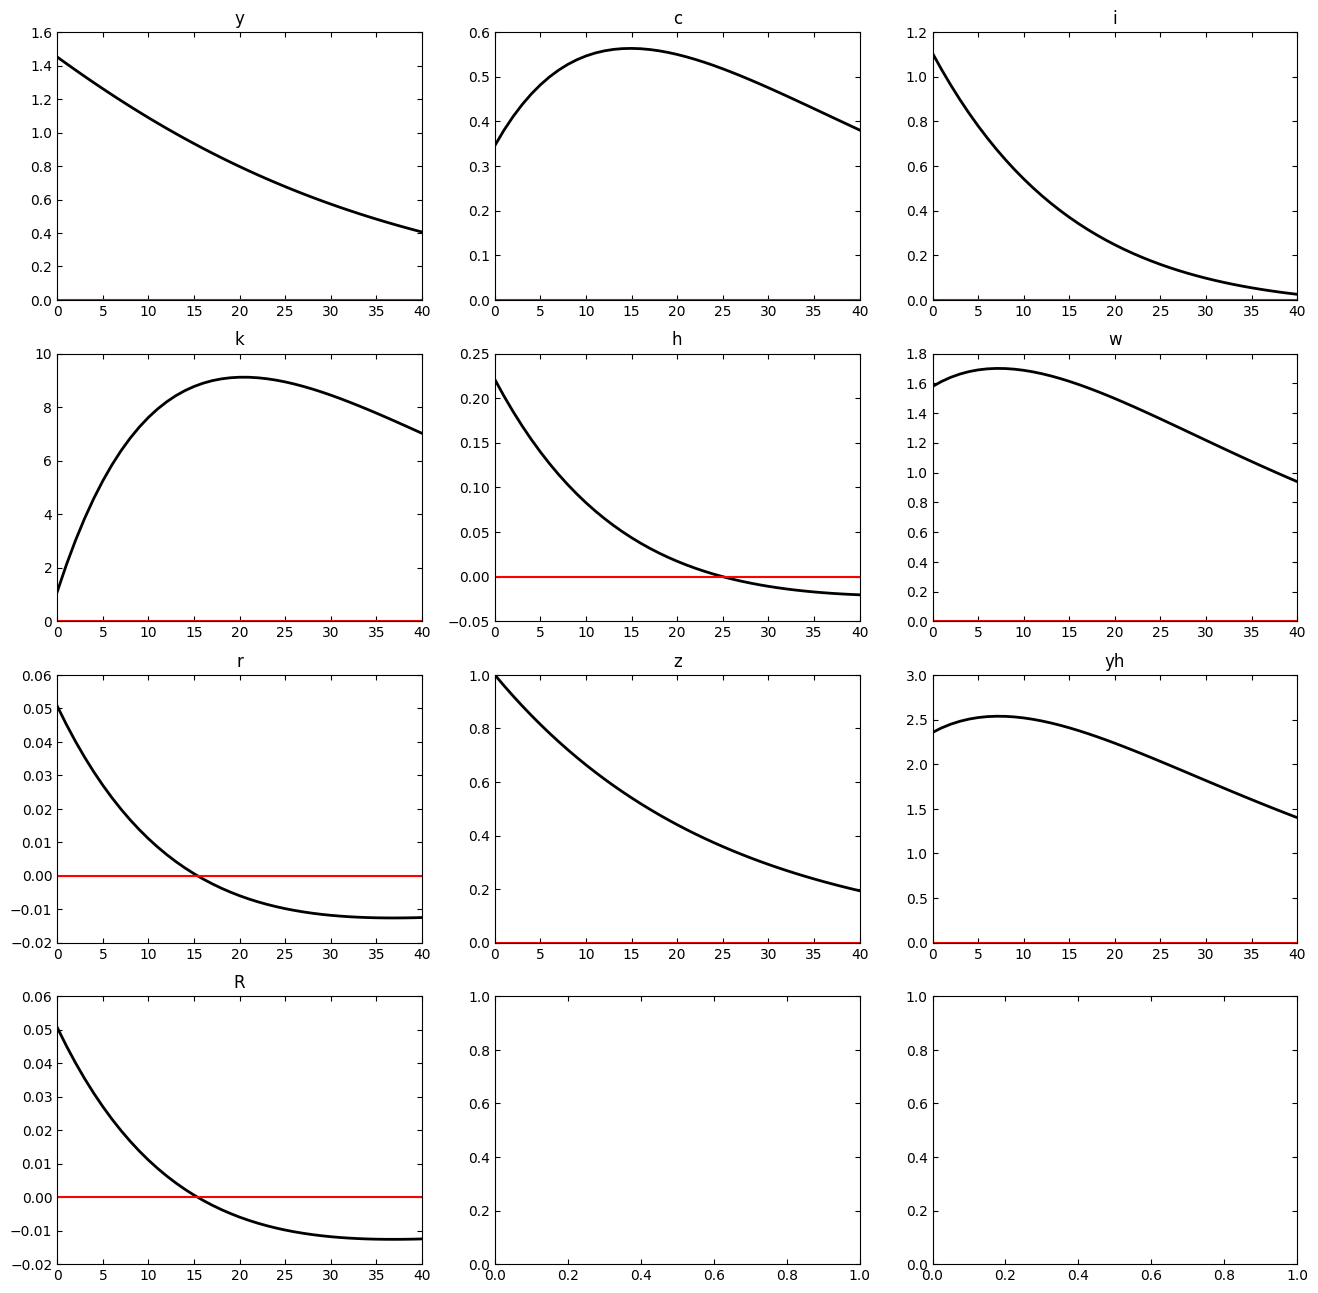

SIMULATED MOMENTS

VARIABLE 	 STD. DEV.
y 		 1.5179
c 		 0.5332
i 		 4.9776
k 		 0.4345
h 		 0.6974
w 		 0.8439
r 		 5.4557
z 		 1.0463
yh 		 0.8439
R 		 0.0535

COEFFICIENTS OF AUTOCORRELATION
y 		 0.7188
c 		 0.7962
i 		 0.7076
k 		 0.9595
h 		 0.7056
w 		 0.7438
r 		 0.7060
z 		 0.7139
yh 		 0.7438
R 		 0.7061

MATRIX OF CORRELATIONS
Variables 	 y
y 		 1.0000
c 		 0.9187
i 		 0.9881
k 		 0.3611
h 		 0.9787
w 		 0.9860
r 		 0.9542
z 		 0.9987
yh 		 0.9860
R 		 0.9586


c:\Users\aaa\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


In [7]:
# Basic model
rbc.steady()
rbc.stoch_simul(irf=40)                                                                                   
rbc.SimulatedMoments(hp_filter=1600, shocks_stderr=stderr_z)   



STEADY-STATE RESULTS

y 	1.0051
c 	0.7689
i 	0.2362
k 	9.4495
h 	0.3333
w 	2.0203
r 	0.0101
z 	1.0000
yh 	3.0153
R 	1.0101

POLICY AND TRANSITION FUNCTIONS

		y	c	i	k	h	w	r	z	yh	R
Constant	1.0051	0.7689	0.2362	9.4495	0.3333	2.0203	0.0101	1.0000	3.0153	1.0101
k(-1) 		0.0173	0.0437	-0.0264	0.9486	-0.0088	0.0882	-0.0031	-0.0000	0.1316	-0.0031
z(-1) 		1.3931	0.3321	1.0610	1.0610	0.2120	1.5151	0.0487	0.9598	2.2613	0.0487
e     		1.4514	0.3460	1.1054	1.1054	0.2209	1.5785	0.0507	1.0000	2.3559	0.0507



	Impulse response functions to e


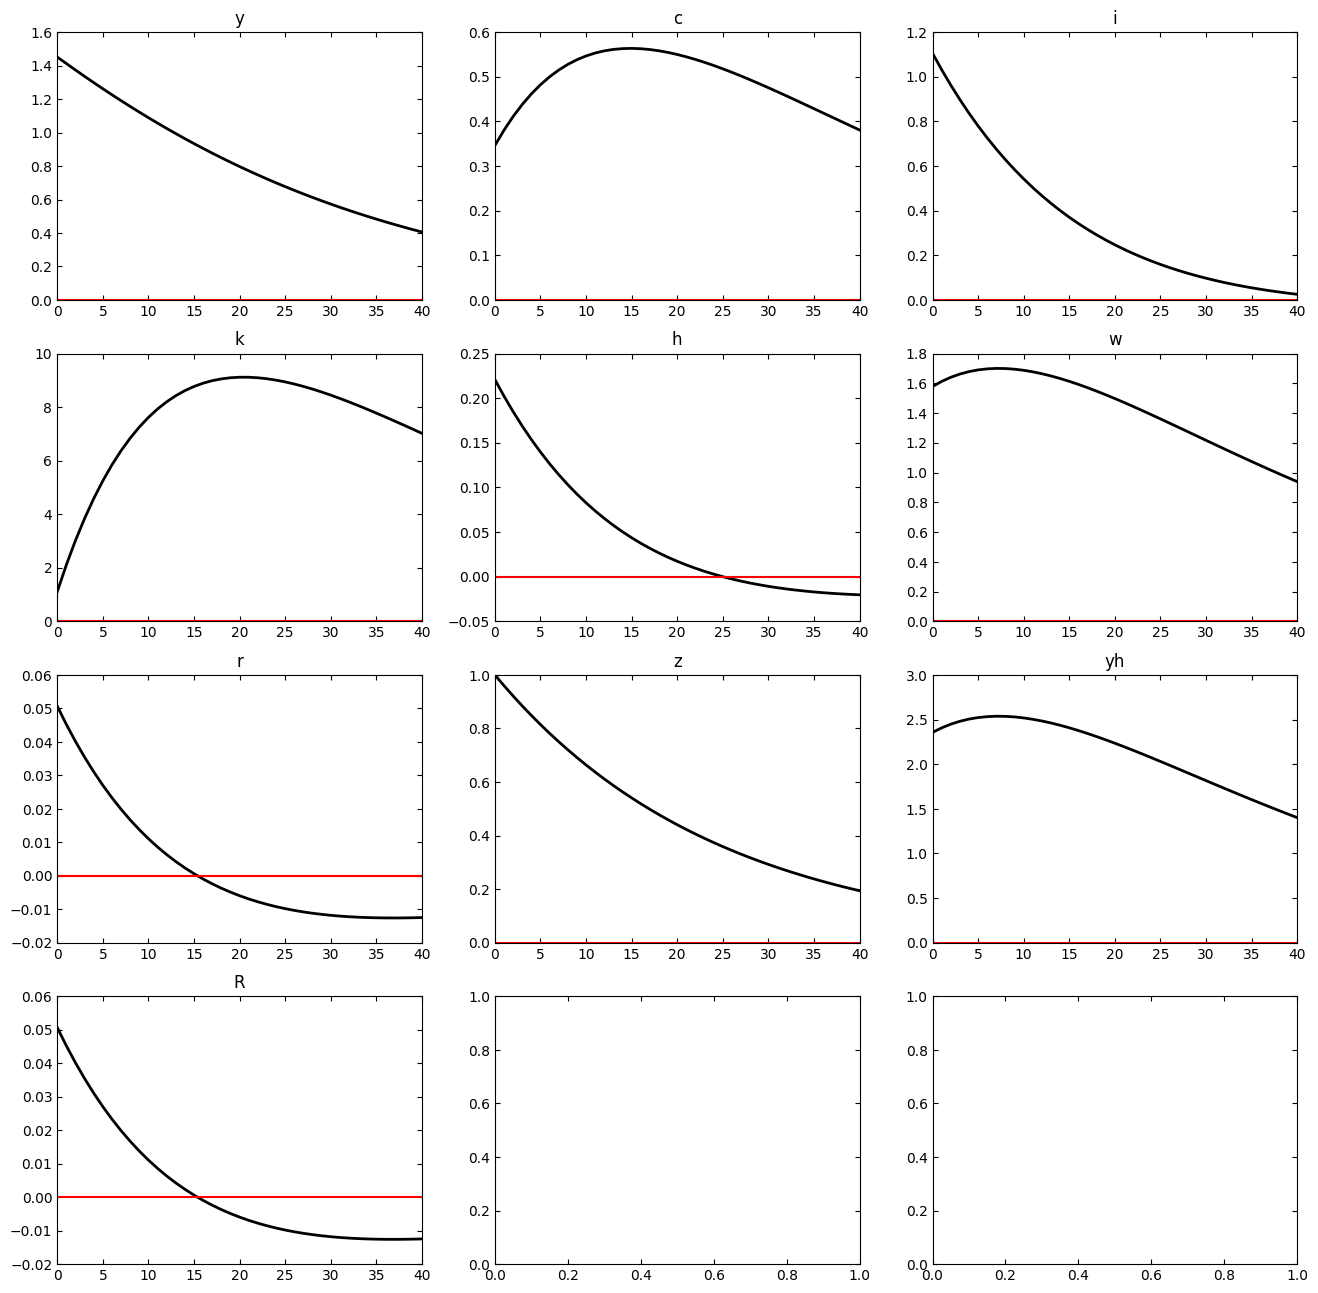

SIMULATED MOMENTS

VARIABLE 	 STD. DEV.
y 		 1.5193
c 		 0.5322
i 		 4.9937
k 		 0.4313
h 		 0.6982
w 		 0.8437
r 		 5.4801
z 		 1.0473
yh 		 0.8437
R 		 0.0535

COEFFICIENTS OF AUTOCORRELATION
y 		 0.7186
c 		 0.7949
i 		 0.7086
k 		 0.9588
h 		 0.7046
w 		 0.7431
r 		 0.7055
z 		 0.7133
yh 		 0.7431
R 		 0.7051

MATRIX OF CORRELATIONS
Variables 	 y
y 		 1.0000
c 		 0.9195
i 		 0.9883
k 		 0.3607
h 		 0.9791
w 		 0.9862
r 		 0.9550
z 		 0.9987
yh 		 0.9862
R 		 0.9593


In [8]:
# Frisch model
rbc_Frisch.steady()
rbc_Frisch.stoch_simul(irf=40)                                                                                                                                                                                                          
rbc_Frisch.SimulatedMoments(hp_filter=1600, shocks_stderr=stderr_z)

### Verification of the Frisch Model

We derived the new optimality condition:
$$\phi h_t^\eta = \frac{w_t}{c_t}$$

To verify our model setup, we ran the simulation with $\eta = 0.5$ (which implies a Frisch elasticity of $1/0.5 = 2$).

**Comparison with Basic RBC:**
* **Output Standard Deviation:** $\approx 1.52$ (very close to the Basic model's 1.59)
* **Hours Standard Deviation:** $\approx 0.70$ (very close to the Basic model's 0.73)

**Conclusion:**
The results are nearly identical to the basic log-log utility model. This confirms that our derivation and code modification are correct.

**Task 3**: Use the alternative parametrization below. Under the new parametrization, compute the simulated moments of the model and compare the relative standard deviation of hours to output with the results we got for the basic RBC model.

In [9]:
param_values_Frisch_alt = {'alpha':0.33, sy.symbols('beta'):0.99, 'delta':0.025, 'phi':2.7759, 'rho':rho_z, 'eta':0.05}

rbc_Frisch_alt = Dynare(var, varexo, param_values_Frisch_alt, model_Frisch, initval)

rbc_Frisch_alt.system
rbc_Frisch_alt.SimulatedMoments(hp_filter=1600, shocks_stderr=stderr_z)

SIMULATED MOMENTS

VARIABLE 	 STD. DEV.
y 		 1.9095
c 		 0.6212
i 		 6.4984
k 		 0.5485
h 		 1.3032
w 		 0.6745
r 		 6.8792
z 		 1.0306
yh 		 0.6745
R 		 0.0672

COEFFICIENTS OF AUTOCORRELATION
y 		 0.7078
c 		 0.7991
i 		 0.6965
k 		 0.9572
h 		 0.6954
w 		 0.7840
r 		 0.6971
z 		 0.7073
yh 		 0.7840
R 		 0.6960

MATRIX OF CORRELATIONS
Variables 	 y
y 		 1.0000
c 		 0.9002
i 		 0.9872
k 		 0.3620
h 		 0.9795
w 		 0.9241
r 		 0.9524
z 		 0.9996
yh 		 0.9241
R 		 0.9582


### Interpretation of Task 3: High Labor Elasticity

In this task, we changed the parameter $\eta$ (eta) from **0.5** to **0.05**.

**What does this mean?**
* The **Frisch Elasticity** of labor supply is defined as $1/\eta$.
* By lowering $\eta$ to 0.05, the elasticity becomes **20** (compared to 2 previously).
* **Economic Intuition:** A high elasticity means workers are **extremely sensitive** to wage changes. If wages go up slightly, they work much more. If wages drop slightly, they work much less. They are very willing to substitute leisure for labor.

**Result Analysis:**
* **Volatility of Hours ($h$):** Exploded from **0.70** to **1.33**.
* **Volatility of Output ($y$):** Increased from **1.52** to **1.94**.

**Conclusion:**
Because workers now react strongly to productivity shocks (which change wages), the number of hours worked fluctuates wildly. This huge swing in labor input causes the total economic output ($y$) to become much more volatile as well. This confirms that **higher labor supply elasticity amplifies business cycles.**